In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

## To delete empty fields

In [2]:
def deleteEmpty(data, col):
    data = data.reset_index(drop=True)
    ind = []
    for i in range(data.shape[0]):
        a = data[col][i]
        try:
            a = float(a)
        except ValueError:
            ind.append(i)
    data = data.drop(data.index[ind])
    data = data.reset_index(drop=True)
    return data.copy()

## Clear whole dataframe

In [3]:
def clear(data):
    data = data.dropna()
    data = deleteEmpty(data, 'Almaty')
    data = deleteEmpty(data, 'Kyzylorda')
    data = deleteEmpty(data, 'Astana')
    data = deleteEmpty(data, 'Atyrau')
    data = deleteEmpty(data, 'Oskemen') 
    data['Almaty'] = data['Almaty'].astype('float64')
    data['Kyzylorda'] = data['Kyzylorda'].astype('float64')
    data['Astana'] = data['Astana'].astype('float64')
    data['Atyrau'] = data['Atyrau'].astype('float64')
    data['Oskemen'] = data['Oskemen'].astype('float64')
    return data.copy()

## Theory about how to use diffence of temperatures of close days to distinct when temperatures are the same, but gas flow us different

In [4]:
def getDiff(data, day):
    my = data[data['day']==day]['Almaty'].mean()
    ago = data[data['day']==(day - 4)]['Almaty'].mean()
    return my - ago

In [5]:
df = pd.read_csv('Dataset2.csv')

## Preprocessing

In [6]:
df = df.dropna()
clear(df)
df['dateandtime'] = pd.to_datetime(df['dateandtime'])
df['day'] = df['dateandtime'].apply(lambda day: day.day)
df['difference'] = df['day'].apply(lambda day: 0 if day <= 18 else abs(getDiff(df, day)))

In [7]:
df.head()

,dateandtime,Gas_Flow,Almaty,Kyzylorda,Astana,Atyrau,Oskemen,day,difference
0,2018-05-01 16:00:00,5921.97,-10.00,-2.8,-12.5,-8.2,-20.8,1,0.0
1,2018-05-01 17:00:00,5943.17,-10.06,-2.9,-12.3,-8.0,-20.7,1,0.0
2,2018-05-01 18:00:00,5938.97,-10.11,-3.0,-12.1,-7.7,-20.7,1,0.0
3,2018-05-01 19:00:00,5998.50,-10.17,-3.1,-11.8,-7.5,-20.6,1,0.0
4,2018-05-01 20:00:00,6009.48,-10.22,-3.2,-11.6,-7.3,-20.6,1,0.0


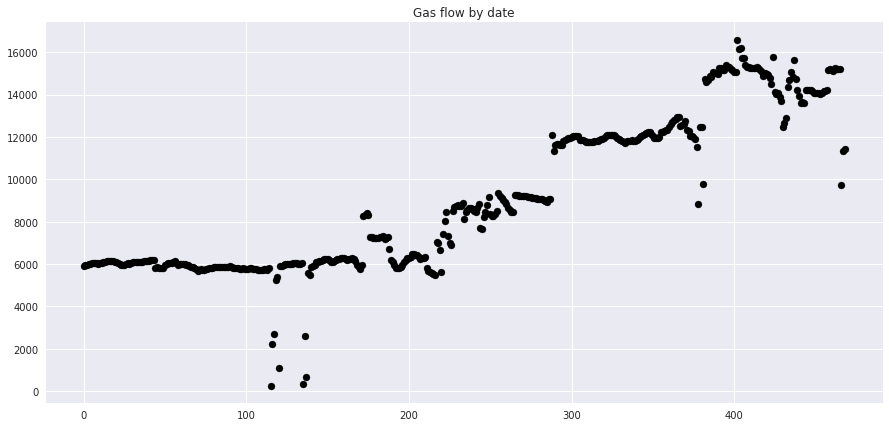

In [8]:
fig = plt.figure(figsize=(15,7))
plt.scatter(range(df.shape[0]), df['Gas_Flow'],color='k')
plt.title('Gas flow by date')
plt.show()

Text(0.5,1,'Temperature by date')

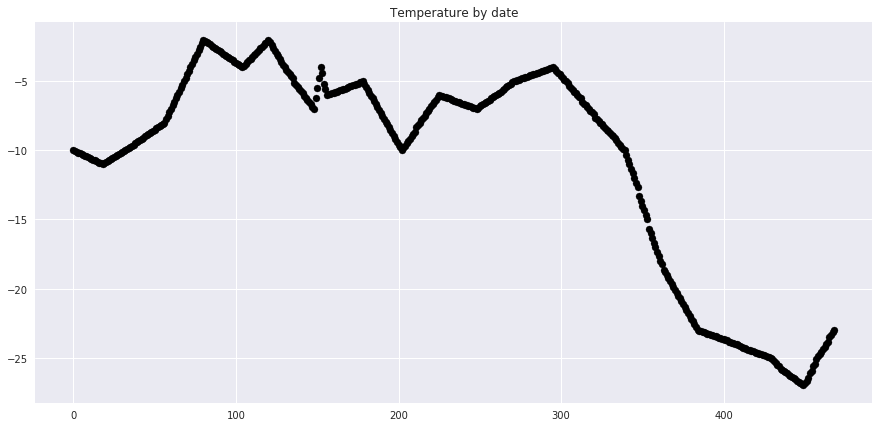

In [9]:
fig = plt.figure(figsize=(15,7))
plt.scatter(range(df.shape[0]), df['Almaty'],color='k')
plt.title('Temperature by date')

In [10]:
corr = df.drop(['dateandtime', 'day' , 'difference'], axis=1).corr()

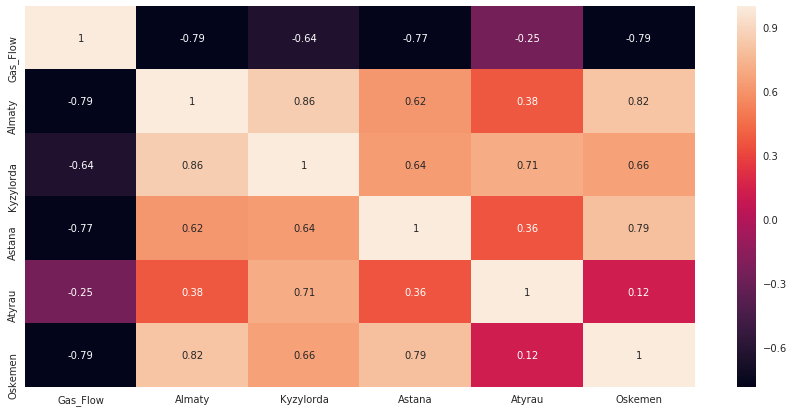

In [11]:
plt.figure(figsize=(15, 7))
sns.heatmap(corr, annot=True)

## 0.7 is enough, dropping everything not needed

In [12]:
dates = df['dateandtime']
df = df.drop(['Kyzylorda', 'Atyrau', 'Astana', 'Oskemen', 'dateandtime', 'day'], axis=1)

plt.scatter(df['Almaty'], df['Gas_Flow'])
plt.title('Gas flow over temperature')

## Used scaler for linear regression

In [13]:

# scaler = StandardScaler()
# scaler.fit(df)
# df['Gas_Flow'] = scaler.transform(df)[:,0]
# df['Almaty'] = scaler.transform(df)[:,1]

In [14]:
df.head()

,Gas_Flow,Almaty,difference
0,5921.97,-10.00,0.0
1,5943.17,-10.06,0.0
2,5938.97,-10.11,0.0
3,5998.50,-10.17,0.0
4,6009.48,-10.22,0.0


## Splitting test and train data

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Gas_Flow', axis=1), df['Gas_Flow'], test_size=0.2, shuffle=True)

## Trying to reduce error using statistic prediction, bad decision

In [16]:
def predict_part(x):
    eps = 3
    sample = x_train[(x - eps < x_train['Almaty']) & (x_train['Almaty'] < x + eps)]
    sample = sample.sort_values('Almaty', ascending=1)
    #sample = sample.reset_index(drop=True)
    #temp = sample['Almaty'].iloc[[len(sample)//2]]
    #return y_train[temp.keys()[0]]
    s = 0
    for d, x in sample.iterrows():
        s += y_train[d]
    return s / len(sample)
        
def predict(X):
    y = []
    for d, x in X.iterrows():
        y.append(predict_part(x['Almaty']))
    return y
print(predict_part(-5))


7591.068031088087


In [17]:
x_train.head()

,Almaty,difference
315,-5.63,2.659308
11,-10.61,0.000000
105,-3.88,0.000000
132,-4.32,0.000000
351,-10.33,7.737964


In [18]:
y_train.head()

315    11838.75
11      6064.24
105     5787.30
132     6025.34
351    11854.85
Name: Gas_Flow, dtype: float64

## Learning and predicting

## Linear Regression

Text(0.5,1,'Train data')

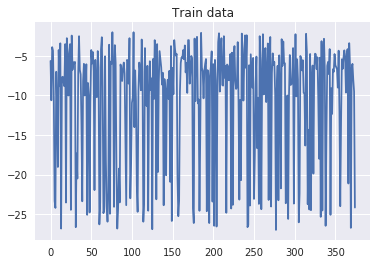

In [19]:
model = LinearRegression()
plt.plot(range(x_train.shape[0]), x_train['Almaty'])
plt.title('Train data')

In [20]:
model.fit(X=x_train,y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

3053702.07164728


Text(0.5,1,'Linear Regression')

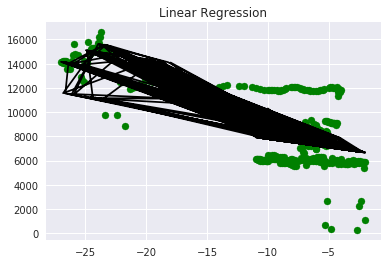

In [21]:
print(mean_squared_error(y_test.as_matrix(), model.predict(x_test)))
plt.scatter(x_train['Almaty'], y_train,color='g')
plt.plot(x_train['Almaty'], model.predict(x_train),color='k')
plt.title('Linear Regression')

## Gradient Boosting Regression

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
reg = GradientBoostingRegressor()

In [24]:
reg.fit(X=x_train,y=y_train)
mean_squared_error(y_test, reg.predict(x_test))

1090948.0512492827

1090948.0512492827


Text(0.5,1,'Gradient Boostring Regression')

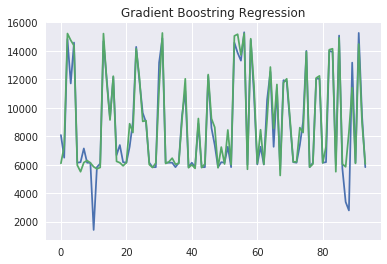

In [25]:
print(mean_squared_error(y_test.as_matrix(), reg.predict(x_test)))
plt.plot(reg.predict(x_test))
plt.plot(y_test.as_matrix())
plt.title('Gradient Boostring Regression')

## Statistic regression

3281513.9816702916


Text(0.5,1,'Statistics')

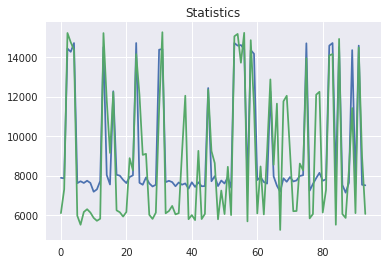

In [26]:
print(mean_squared_error(y_test.as_matrix(), predict(x_test)))
plt.plot(predict(x_test))
plt.plot(y_test.as_matrix())
plt.title('Statistics')